In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import time
from tqdm import tqdm
import numpy as np
import os
import math
from os.path import join
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import random

In [10]:
test_tensor = torch.randn(32,2,256,256)
test_lambda = torch.randn(32,1,256,256)
chan_res = test_tensor[:,:1,:,:] * test_lambda
print(chan_res.shape)

torch.Size([32, 1, 256, 256])


In [3]:
def show(img, title='',cmap=None): 
    img = np.squeeze(img)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()
    
def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

dict_keys(['epoch', 'best_loss', 'model_state_dict', 'optimizer_state_dict', 'hist_train_loss', 'hist_valid_loss', 'hist_lr', 'params'])


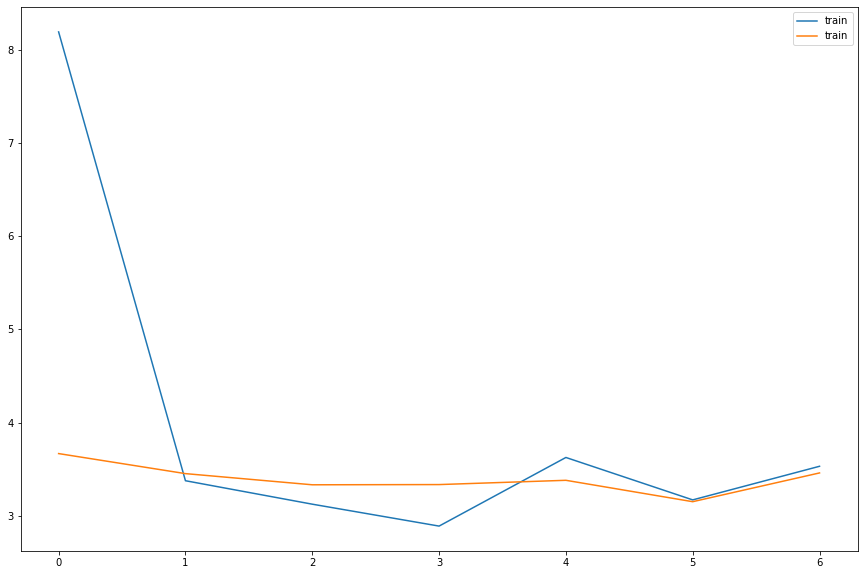

In [5]:
check_point = torch.load('weights/pred_touch.pt')
print(check_point.keys())

plt.figure(figsize=(15,10))
plt.plot(check_point['hist_train_loss'], label='train')
plt.plot(check_point['hist_valid_loss'], label='train')
plt.legend()
plt.show()

In [4]:
from ssn.random_pattern import random_pattern
from ssn.ssn import Relight_SSN

# experiment of fovs

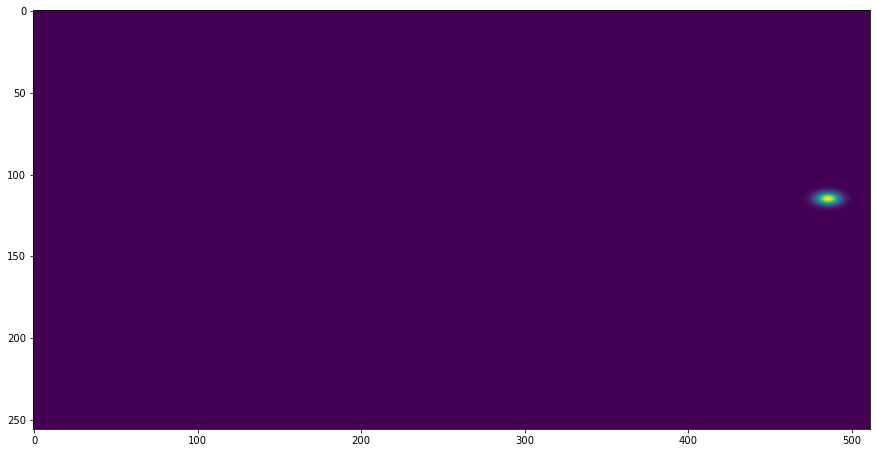

In [52]:
import imagen as ig

gs = ig.Composite(operator=np.add,
                          generators=[ig.Gaussian(
                              size=0.02,
                              scale=3.0,
                              x=0.45,
                              y=0.05,
                              aspect_ratio=1.0,
                          ) for i in range(1)],
                          xdensity=512)

test_ibl = gs()
show(test_ibl)

In [6]:
baseline_model = Relight_SSN(1,1)
baseline_checkpoint = torch.load('weights/fov_22-September-04-41-PM.pt')

device = torch.device('cuda:0')
baseline_model.to(device)

baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
test_folder = '/home/ysheng/Dataset/fov_exp_test/mask/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/'
files = get_files(test_folder)
print("files: {}".format(len(files)))

files: 100


In [32]:
def net_render_np(model, mask_np, ibl_np):
    """
    input:
        mask_np shape: b x c x h x w
        ibl_np shape: 1 x 16 x 32
    output:
        shadow_predict shape: b x c x h x w
    """
    s = time.time()
    if mask_np.dtype == np.uint8:
        mask_np = mask_np/255.0

    mask, ibl = torch.Tensor(mask_np), torch.Tensor(ibl_np)
    with torch.no_grad():
        I_s, L_t = mask.to(device), ibl.to(device)
        # print('I_s: {}, L_t: {}'.format(I_s.shape, L_t.shape))
        predicted_img, predicted_src_light = model(I_s, L_t)

    print('net predict finished, time: {}s'.format(time.time() -s))
    
    return predicted_img.detach().cpu().numpy()

In [54]:
input_ibl = cv2.flip(cv2.resize(test_ibl, (32,16)), 0)
input_ibl = input_ibl/np.sum(input_ibl) * 30.0
input_ibl = input_ibl[np.newaxis,:,:]
print(input_ibl.shape)

(1, 16, 32)


In [55]:
output_folder = 'fov_result'
os.makedirs(output_folder, exist_ok=True)

for i,mask_file in enumerate(tqdm(files)):
    mask_np = plt.imread(mask_file)
    mask_input = mask_np[:,:,:1]
    mask_input = np.transpose(mask_input, (2,0,1))
    mask_input = mask_input[np.newaxis, :,:,:]
    output = net_render_np(baseline_model, mask_input, input_ibl)
    output = np.transpose(output[0], (1,2,0))
    
    output = np.squeeze(output)
    cv2.normalize(output, output, 0.0,1.0,cv2.NORM_MINMAX)
    output = output + mask_np[:,:,0]
    output = output[:,:,np.newaxis]
    output = np.clip(output, 0.0, 1.0)
    output = np.repeat(output, 3, axis=2)
    plt.imsave(join(output_folder, '{:04d}.png'.format(i)), np.squeeze(output))

  5%|▌         | 5/100 [00:00<00:01, 48.24it/s]

net predict finished, time: 0.010761022567749023s
net predict finished, time: 0.0053157806396484375s
net predict finished, time: 0.005089282989501953s
net predict finished, time: 0.005246400833129883s
net predict finished, time: 0.004613399505615234s
net predict finished, time: 0.0045855045318603516s
net predict finished, time: 0.0044629573822021484s
net predict finished, time: 0.004422664642333984s
net predict finished, time: 0.004380702972412109s
net predict finished, time: 0.004280805587768555s
net predict finished, time: 0.0044100284576416016s


 23%|██▎       | 23/100 [00:00<00:01, 54.07it/s]

net predict finished, time: 0.005089521408081055s
net predict finished, time: 0.0043485164642333984s
net predict finished, time: 0.004456758499145508s
net predict finished, time: 0.004560708999633789s
net predict finished, time: 0.00472569465637207s
net predict finished, time: 0.004662036895751953s
net predict finished, time: 0.004526376724243164s
net predict finished, time: 0.004400730133056641s
net predict finished, time: 0.0045070648193359375s
net predict finished, time: 0.004189491271972656s
net predict finished, time: 0.004130125045776367s
net predict finished, time: 0.004268646240234375s


 35%|███▌      | 35/100 [00:00<00:01, 56.14it/s]

net predict finished, time: 0.005026817321777344s
net predict finished, time: 0.004211902618408203s
net predict finished, time: 0.004305601119995117s
net predict finished, time: 0.004332542419433594s
net predict finished, time: 0.004648447036743164s
net predict finished, time: 0.004426479339599609s
net predict finished, time: 0.00455474853515625s
net predict finished, time: 0.004465341567993164s
net predict finished, time: 0.004502058029174805s
net predict finished, time: 0.004587650299072266s
net predict finished, time: 0.004509687423706055s
net predict finished, time: 0.004477739334106445s


 41%|████      | 41/100 [00:00<00:01, 56.90it/s]

net predict finished, time: 0.0047626495361328125s
net predict finished, time: 0.004410266876220703s
net predict finished, time: 0.004382133483886719s
net predict finished, time: 0.004506111145019531s
net predict finished, time: 0.004533290863037109s
net predict finished, time: 0.004436969757080078s
net predict finished, time: 0.0045185089111328125s
net predict finished, time: 0.0042498111724853516s
net predict finished, time: 0.004296064376831055s
net predict finished, time: 0.0045316219329833984s
net predict finished, time: 0.0066144466400146484s
net predict finished, time: 0.004781961441040039s


 53%|█████▎    | 53/100 [00:00<00:00, 56.19it/s]

net predict finished, time: 0.004469633102416992s
net predict finished, time: 0.004490375518798828s
net predict finished, time: 0.0047838687896728516s
net predict finished, time: 0.004220247268676758s
net predict finished, time: 0.0043163299560546875s
net predict finished, time: 0.0042111873626708984s
net predict finished, time: 0.010774850845336914s
net predict finished, time: 0.005876779556274414s
net predict finished, time: 0.004416704177856445s
net predict finished, time: 0.0044252872467041016s
net predict finished, time: 0.004393815994262695s
net predict finished, time: 0.0043447017669677734s


 65%|██████▌   | 65/100 [00:01<00:00, 55.10it/s]

net predict finished, time: 0.005616188049316406s
net predict finished, time: 0.004281759262084961s
net predict finished, time: 0.004462242126464844s
net predict finished, time: 0.0044400691986083984s
net predict finished, time: 0.0043621063232421875s
net predict finished, time: 0.0042934417724609375s
net predict finished, time: 0.00426793098449707s
net predict finished, time: 0.004338502883911133s
net predict finished, time: 0.004459381103515625s
net predict finished, time: 0.004149675369262695s
net predict finished, time: 0.00417327880859375s
net predict finished, time: 0.004102230072021484s


 83%|████████▎ | 83/100 [00:01<00:00, 57.12it/s]

net predict finished, time: 0.004164457321166992s
net predict finished, time: 0.004297494888305664s
net predict finished, time: 0.004463911056518555s
net predict finished, time: 0.004320621490478516s
net predict finished, time: 0.004239797592163086s
net predict finished, time: 0.004264116287231445s
net predict finished, time: 0.004622220993041992s
net predict finished, time: 0.004266977310180664s
net predict finished, time: 0.0043163299560546875s
net predict finished, time: 0.004216909408569336s
net predict finished, time: 0.004289150238037109s
net predict finished, time: 0.004321098327636719s


 89%|████████▉ | 89/100 [00:01<00:00, 54.88it/s]

net predict finished, time: 0.004454135894775391s
net predict finished, time: 0.004374980926513672s
net predict finished, time: 0.004413127899169922s
net predict finished, time: 0.004304170608520508s
net predict finished, time: 0.004697561264038086s
net predict finished, time: 0.004477262496948242s
net predict finished, time: 0.00468754768371582s
net predict finished, time: 0.004512310028076172s
net predict finished, time: 0.0042874813079833984s
net predict finished, time: 0.0043048858642578125s
net predict finished, time: 0.004488706588745117s


100%|██████████| 100/100 [00:01<00:00, 55.73it/s]

net predict finished, time: 0.004494667053222656s
net predict finished, time: 0.004359006881713867s
net predict finished, time: 0.004302263259887695s
net predict finished, time: 0.0043201446533203125s
net predict finished, time: 0.004305839538574219s
net predict finished, time: 0.004387855529785156s


In [17]:
baseline_model, sketch_model = Relight_SSN(1,1), Relight_SSN(2,1)
baseline_checkpoint = torch.load('weights/human_baseline_21-September-04-14-PM.pt')
print(baseline_checkpoint.keys())

dict_keys(['epoch', 'best_loss', 'model_state_dict', 'optimizer_state_dict', 'hist_train_loss', 'hist_valid_loss', 'hist_lr', 'params'])


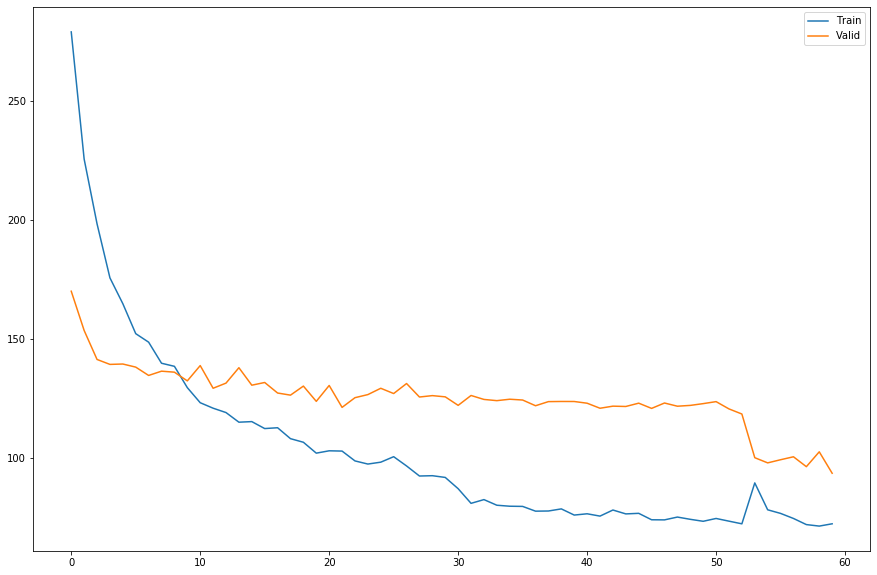

In [18]:
# train and validation
plt.figure(figsize=(15,10))
plt.plot(baseline_checkpoint['hist_train_loss'], label='Train')
plt.plot(baseline_checkpoint['hist_valid_loss'], label='Valid')
plt.legend()
plt.show()

dict_keys(['epoch', 'best_loss', 'model_state_dict', 'optimizer_state_dict', 'hist_train_loss', 'hist_valid_loss', 'hist_lr', 'params'])


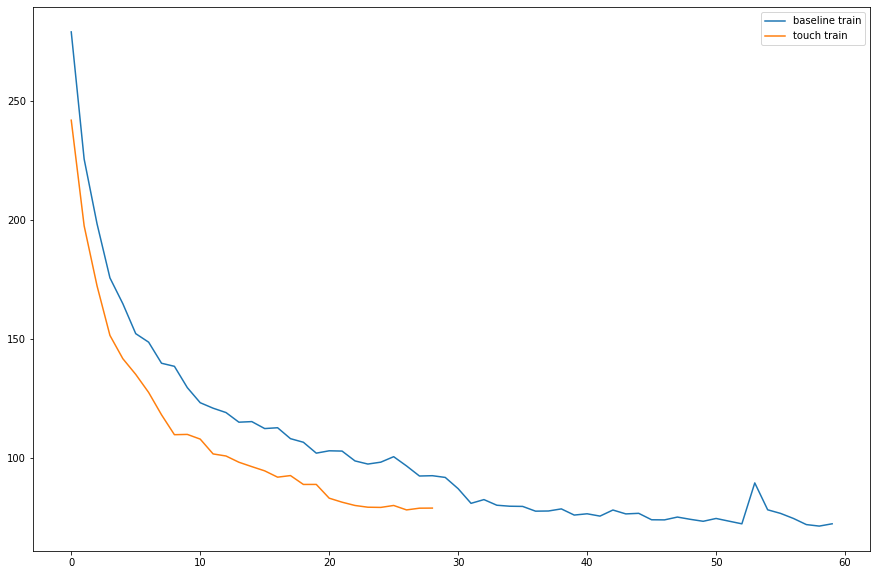

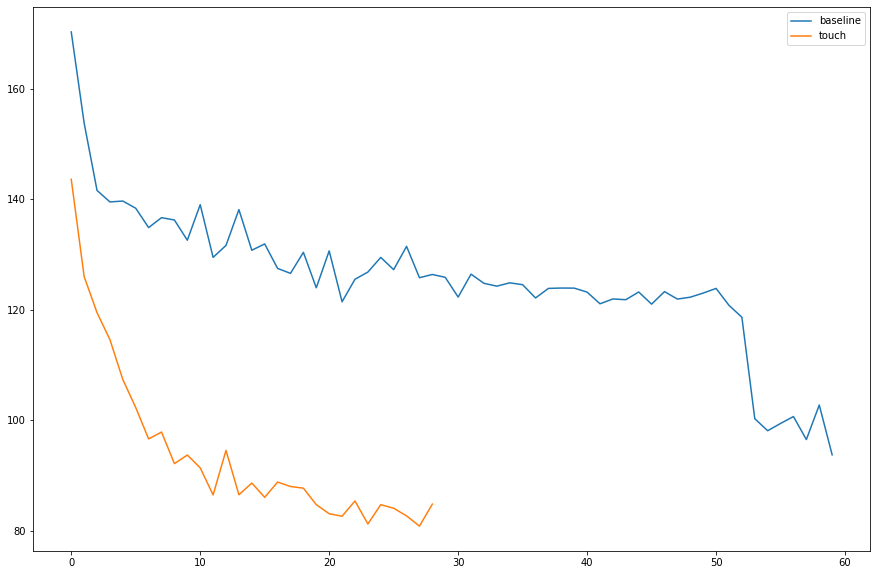

In [22]:
# different methods
print(baseline_checkpoint.keys())

plt.figure(figsize=(15,10))
plt.plot(baseline_checkpoint['hist_train_loss'], label='baseline train')
plt.plot(touch_checkpoint['hist_train_loss'], label='touch train')
plt.legend()
plt.savefig('train_compare.png')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(baseline_checkpoint['hist_valid_loss'], label='baseline')
plt.plot(touch_checkpoint['hist_valid_loss'], label='touch')
plt.legend()
plt.savefig('valid_compare.png')
plt.show()

In [17]:
baseline_model, sketch_model = Relight_SSN(1,1), Relight_SSN(2,1)
baseline_checkpoint, touch_checkpoint = torch.load('weights/human_baseline_21-September-04-14-PM.pt'), torch.load('weights/human_touch_train_29-September-04-30-PM.pt')

device = torch.device('cuda:0')
baseline_model.to(device)
sketch_model.to(device)

baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
sketch_model.load_state_dict(sketch_checkpoint['model_state_dict'])

<All keys matched successfully>

In [72]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, img, is_transpose=True):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        if is_transpose:
            img = img.transpose((2, 0, 1))
        return torch.Tensor(img)

def to_model_input(mask_file, light, sketch_file=None, device=torch.device('cuda:0')):
    to_tensor = ToTensor()
    
    mask_img = plt.imread(mask_file)
    mask_img = mask_img[:,:,0]
    mask_img = mask_img[:,:,np.newaxis]
    light = light[:,:,np.newaxis]
    
    if sketch_file is None:
        return torch.unsqueeze(to_tensor(mask_img), 0).to(device), torch.unsqueeze(to_tensor(light),0).to(device)
    else:
        sketch_img = plt.imread(sketch_file)
        sketch_img = sketch_img[:,:,0] + sketch_img[:,:,1] + sketch_img[:,:,2]
        sketch_img = sketch_img/np.max(sketch_img)
        sketch_img = sketch_img[:,:,np.newaxis]
        
        mask_img = torch.unsqueeze(to_tensor(mask_img), 0)
        sketch_img = torch.unsqueeze(to_tensor(sketch_img), 0)
        
        return torch.cat([mask_img, sketch_img], dim=1).to(device), to_tensor(light).to(device) 
    
def get_gt(shadow_base_file, light):
    shadow_base = 1.0 - np.load(shadow_base_file)
    return np.tensordot(shadow_base, light, axes=([2,3], [1, 0]))

def loss(gt, pred):
    return np.linalg.norm(gt-pred)

In [ ]:
exp_num = 50
mask_root = 'dataset/general_dataset/mask/'
sketch_root = 'dataset/general_dataset/sketch/'
base_root = 'dataset/general_dataset/base/'

pattern_generator = random_pattern()

result_dict = {}
random.seed(19920208)
for model in tqdm(all_models):
    model_name = os.path.basename(model)
    mask_files = get_files(join(mask_root, model_name))
    sketch_files = get_files(join(sketch_root, model_name))
    base_loss, sket_loss = [],[]
    
    for i in range(exp_num):
        mask = random.sample(mask_files, 1)[0]
        prefix = os.path.basename(mask)
        prefix = prefix[:prefix.find('_mask')]
        sketch = join(sketch_root, join(model_name, prefix + '_sketch.png'))
        shadow_base_file = join(base_root, join(model_name, prefix+'_shadow.npy'))
        
        light = pattern_generator.get_pattern(32, 16, num=random.randint(0,50), dataset=True)
        gt = get_gt(shadow_base_file, light)
        
        I_s,L_t = to_model_input(mask, light, device=device)
        base_pred_img, _ = baseline_model(I_s,L_t)
        base_pred_img = np.transpose(base_pred_img.cpu().detach().numpy()[0], (1,2,0))
        
        I_s, L_t = to_model_input(mask, light, sketch, device=device)
        sket_pred_img, _ = sketch_model(I_s, L_t)
        sket_pred_img = np.transpose(sket_pred_img.cpu().detach().numpy()[0], (1,2,0))
        
        gt = gt[:,:, np.newaxis]
        base_loss.append(loss(gt, base_pred_img))
        sket_loss.append(loss(gt, sket_pred_img))
    
    result_dict[model_name] = [base_loss, sket_loss]

In [94]:
import pandas as pd
import seaborn as sns

In [95]:
data = []
for k,v in tqdm(result_dict.items()):
    name = k
    v_np = np.array(v)
    base, sket = v_np[0], v_np[1]
    
    cur_data = []
    for b in base:
        cur_data.append([name, 'base', b])
    
    for s in sket:
        cur_data.append([name, 'sket', s])
        
    data += cur_data














100%|██████████| 85/85 [00:00<00:00, 12651.83it/s]


In [96]:
df = pd.DataFrame(data=data, columns=['name', 'type', 'loss'])
df

,name,type,loss
0,table_0159,base,330.551162
1,table_0159,base,258.895088
2,table_0159,base,353.780630
3,table_0159,base,252.793255
4,table_0159,base,312.733481
...,...,...,...
8495,monitor_0184,sket,279.724861
8496,monitor_0184,sket,324.938382
8497,monitor_0184,sket,215.208056
8498,monitor_0184,sket,283.695696


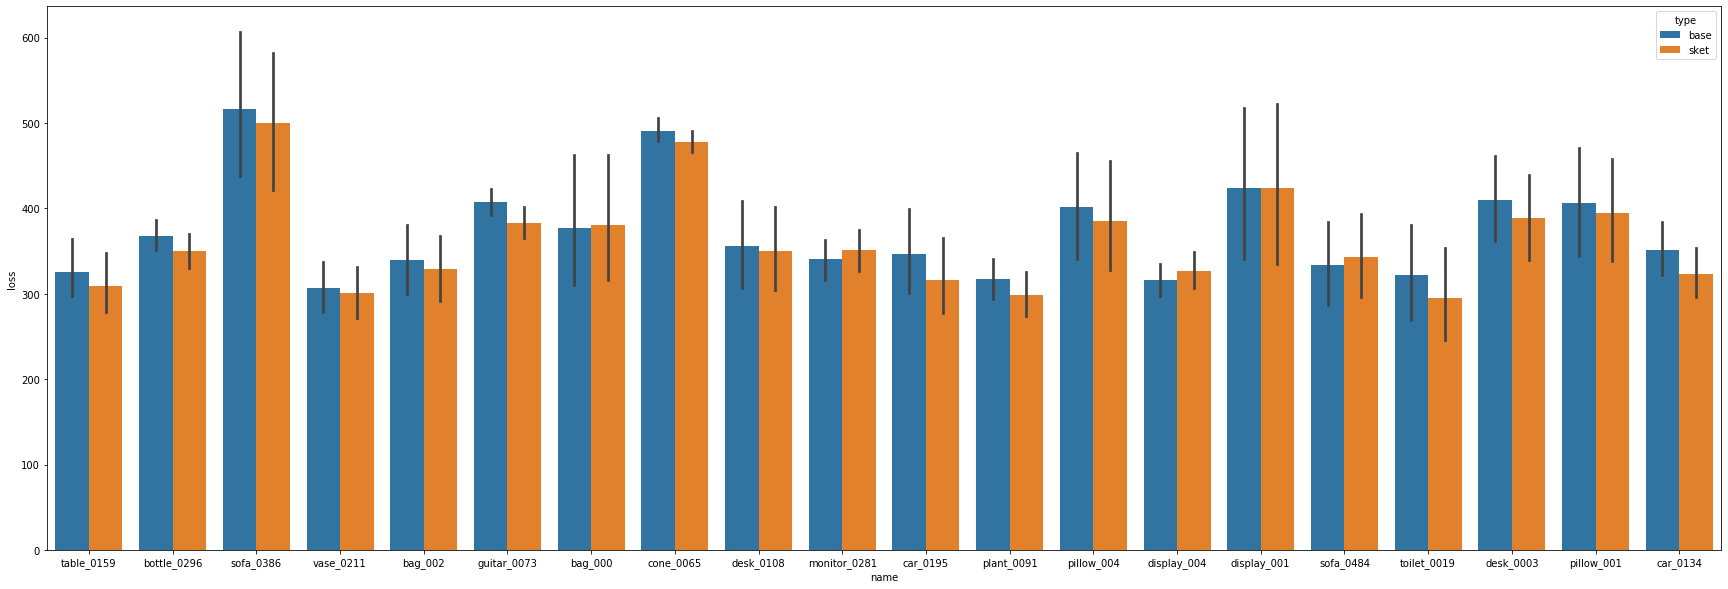

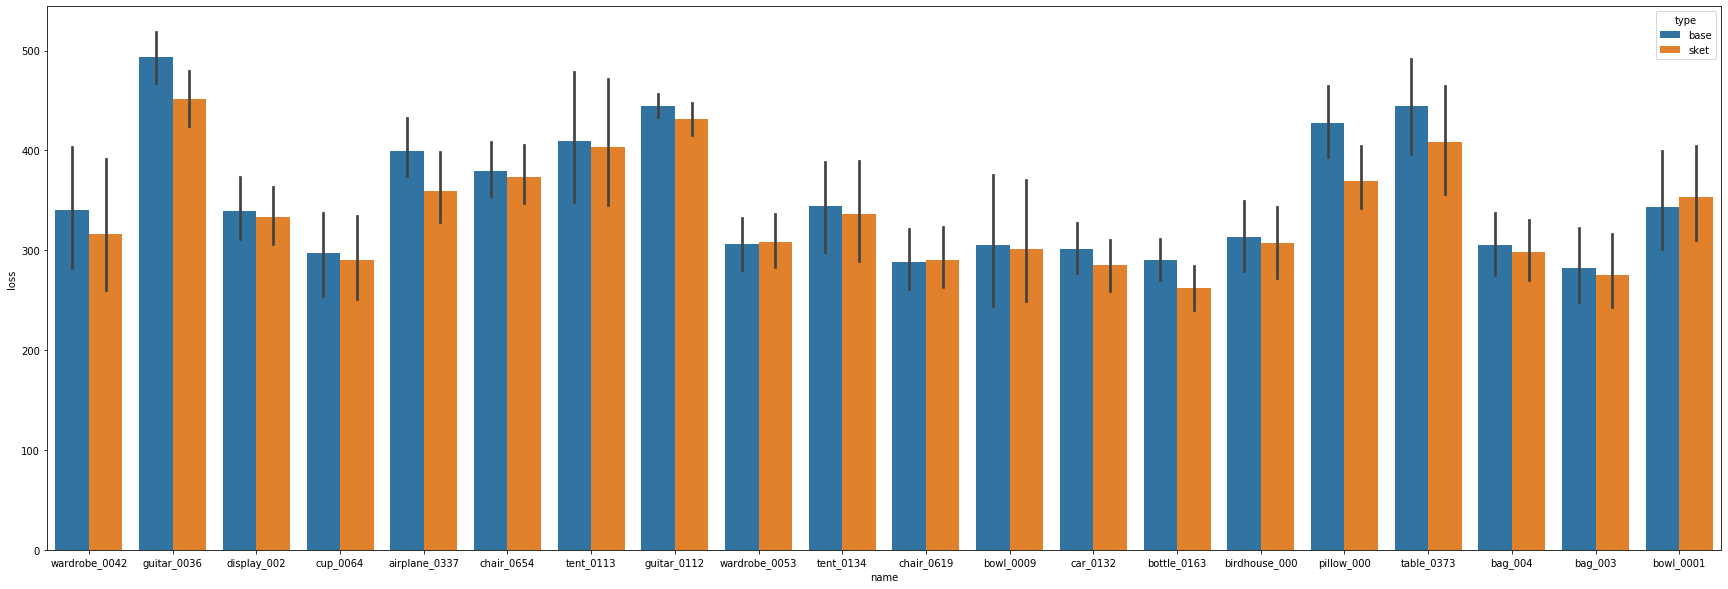

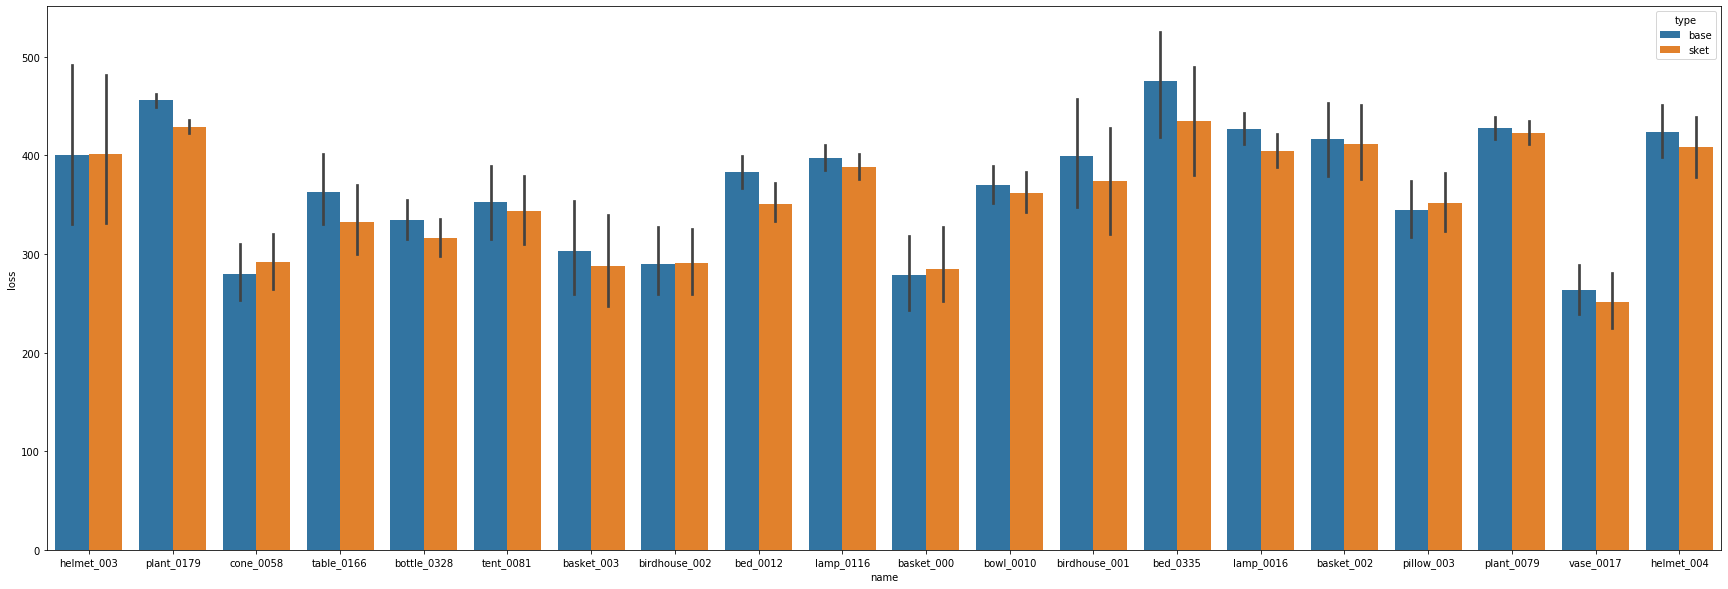

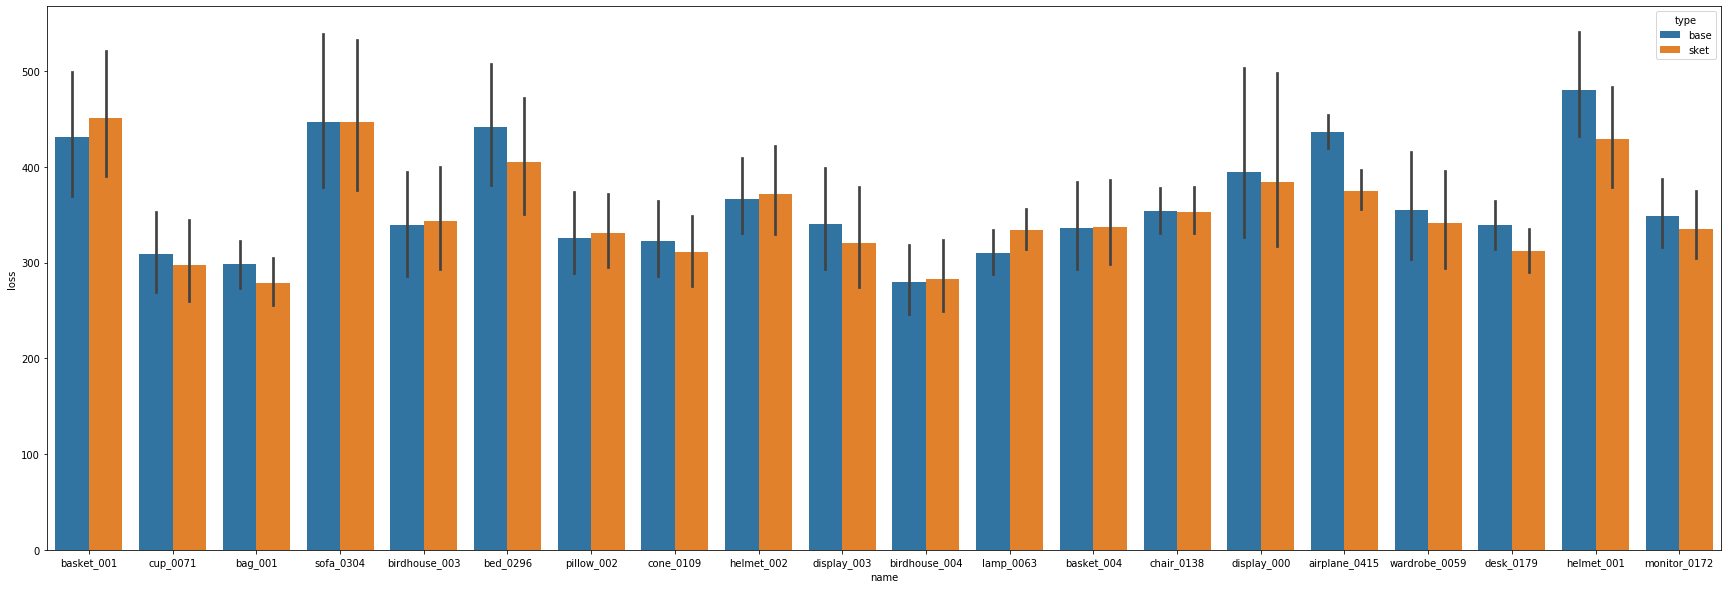

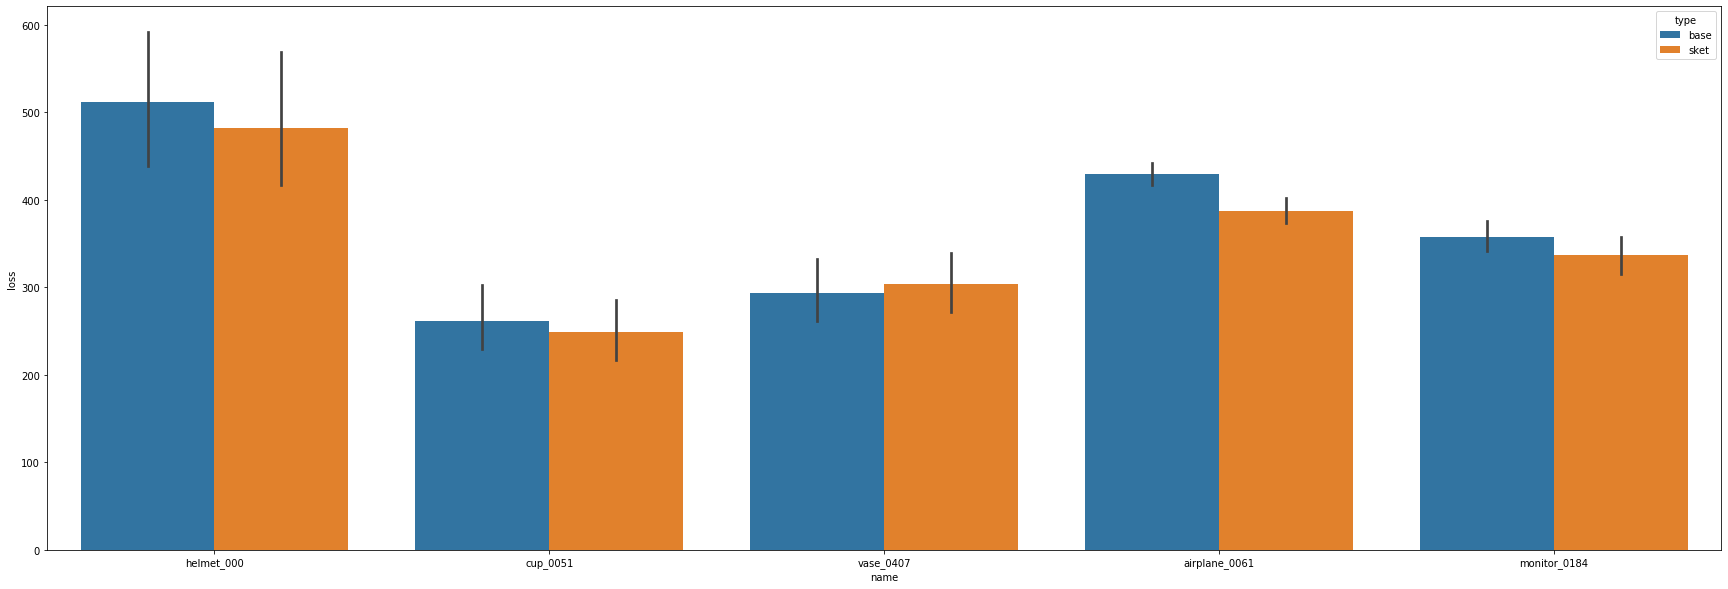

In [100]:
name_list = df.name.unique()

selected_df = df[df['name'].isin(name_list[:20])]
plt.figure(figsize=(15 * 2,10))
ax = sns.barplot(x='name', y='loss', hue='type', data=selected_df)

selected_df = df[df['name'].isin(name_list[20:40])]
plt.figure(figsize=(15 * 2,10))
ax = sns.barplot(x='name', y='loss', hue='type', data=selected_df)

selected_df = df[df['name'].isin(name_list[40:60])]
plt.figure(figsize=(15 * 2,10))
ax = sns.barplot(x='name', y='loss', hue='type', data=selected_df)

selected_df = df[df['name'].isin(name_list[60:80])]
plt.figure(figsize=(15 * 2,10))
ax = sns.barplot(x='name', y='loss', hue='type', data=selected_df)

selected_df = df[df['name'].isin(name_list[80:])]
plt.figure(figsize=(15 * 2,10))
ax = sns.barplot(x='name', y='loss', hue='type', data=selected_df)

In [102]:
display(df)

data=[]
for name in tqdm(name_list):
    cur_df = df[df['name'] == name]
    base_df = cur_df[cur_df['type'] == 'base']
    sket_df = cur_df[cur_df['type'] == 'sket']
    
    data.append([name, np.average(base_df['loss'].to_numpy()), np.var(base_df['loss'].to_numpy()), np.average(sket_df['loss'].to_numpy()), np.var(sket_df['loss'].to_numpy())])
    

,name,type,loss
0,table_0159,base,330.551162
1,table_0159,base,258.895088
2,table_0159,base,353.780630
3,table_0159,base,252.793255
4,table_0159,base,312.733481
...,...,...,...
8495,monitor_0184,sket,279.724861
8496,monitor_0184,sket,324.938382
8497,monitor_0184,sket,215.208056
8498,monitor_0184,sket,283.695696















  0%|          | 0/85 [00:00<?, ?it/s]












 36%|███▋      | 31/85 [00:00<00:00, 303.31it/s]












100%|██████████| 85/85 [00:00<00:00, 341.96it/s]


In [104]:
result_df = pd.DataFrame(data=data, columns=['name', 'base_avg', 'base_var', 'sket_avg', 'sket_var'])
result_df = result_df[['name', 'base_avg', 'sket_avg', 'base_var', 'base_var']]
display(result_df)

,name,base_avg,sket_avg,base_var,base_var
0,table_0159,326.019469,309.495800,14669.804079,14669.804079
1,bottle_0296,367.513327,350.449854,3840.861553,3840.861553
2,sofa_0386,516.800718,499.929710,90061.528408,90061.528408
3,vase_0211,306.791776,300.627761,11386.158270,11386.158270
4,bag_002,339.405932,328.748082,20314.496712,20314.496712
...,...,...,...,...,...
80,helmet_000,511.384144,482.020326,76176.932141,76176.932141
81,cup_0051,261.760816,249.380475,17276.327917,17276.327917
82,vase_0407,293.797553,303.844197,15602.306555,15602.306555
83,airplane_0061,428.826791,387.025320,2217.992410,2217.992410


In [118]:
base_min, sket_min, base_max, sket_max = result_df['base_avg'].argmin(), result_df['sket_avg'].argmin(), result_df['base_avg'].argmax(), result_df['sket_avg'].argmax()
print('base min: {}, sket min: {}, base max: {}, sket_max: {}'.format(result_df.loc[base_min, 'name'], result_df.loc[sket_min, 'name'], result_df.loc[base_max, 'name'],result_df.loc[sket_max, 'name']))

base min: cup_0051, sket min: cup_0051, base max: sofa_0386, sket_max: sofa_0386


In [119]:
result_df.to_csv('2020_8_11_general_obj.csv')

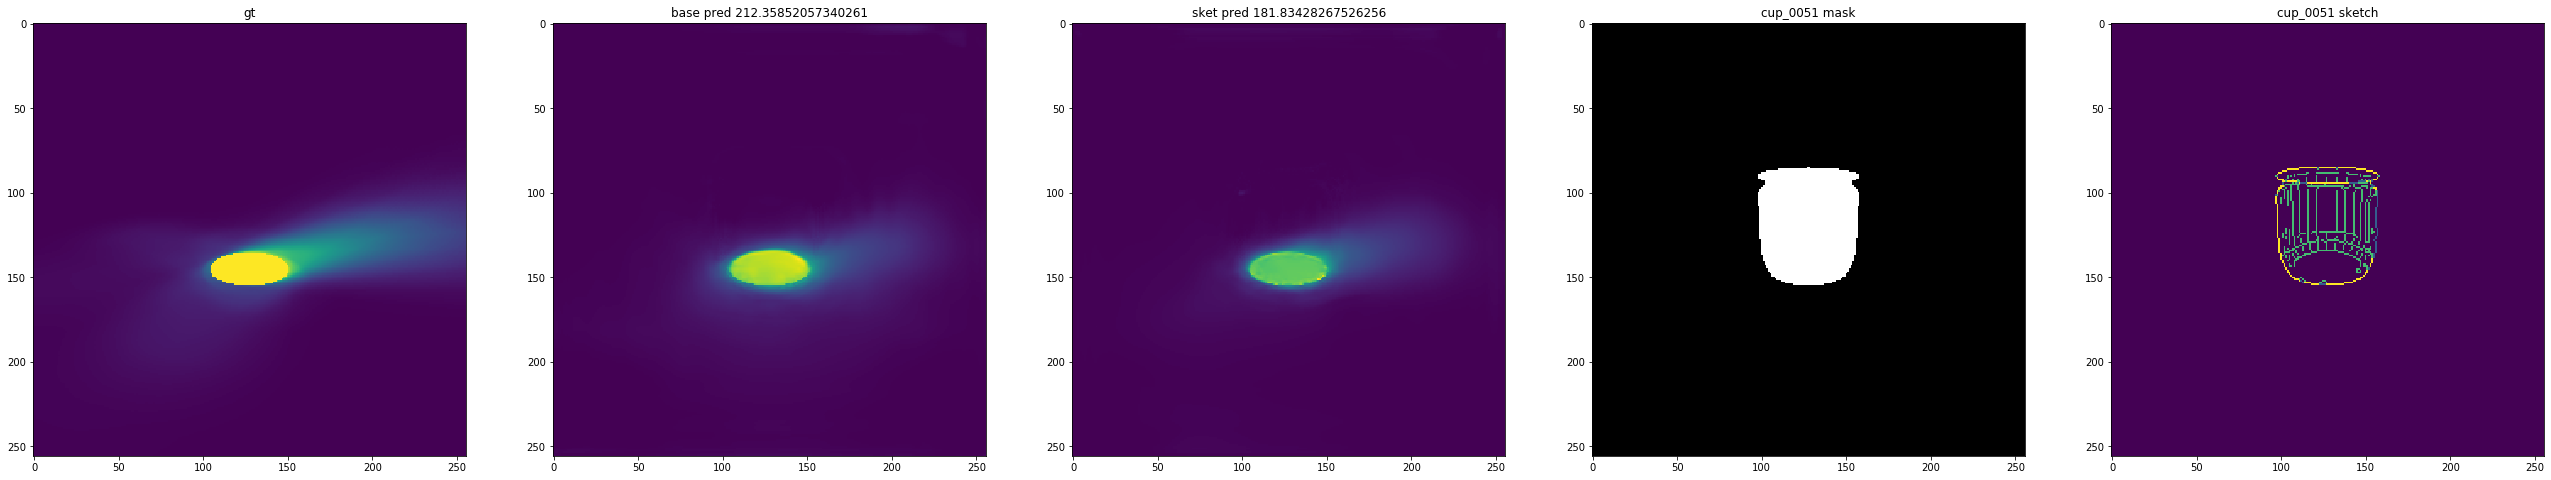

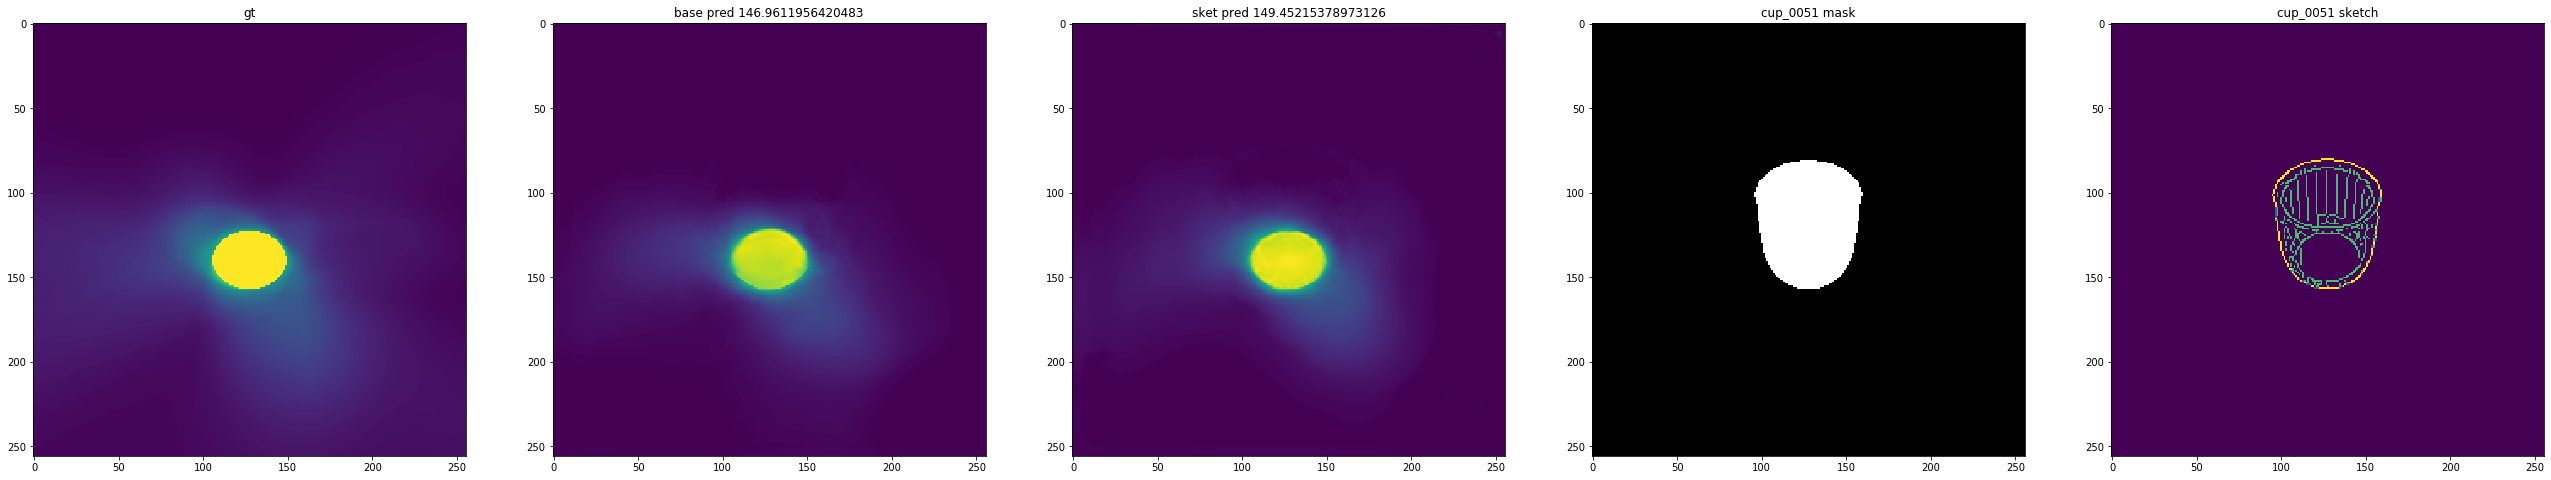

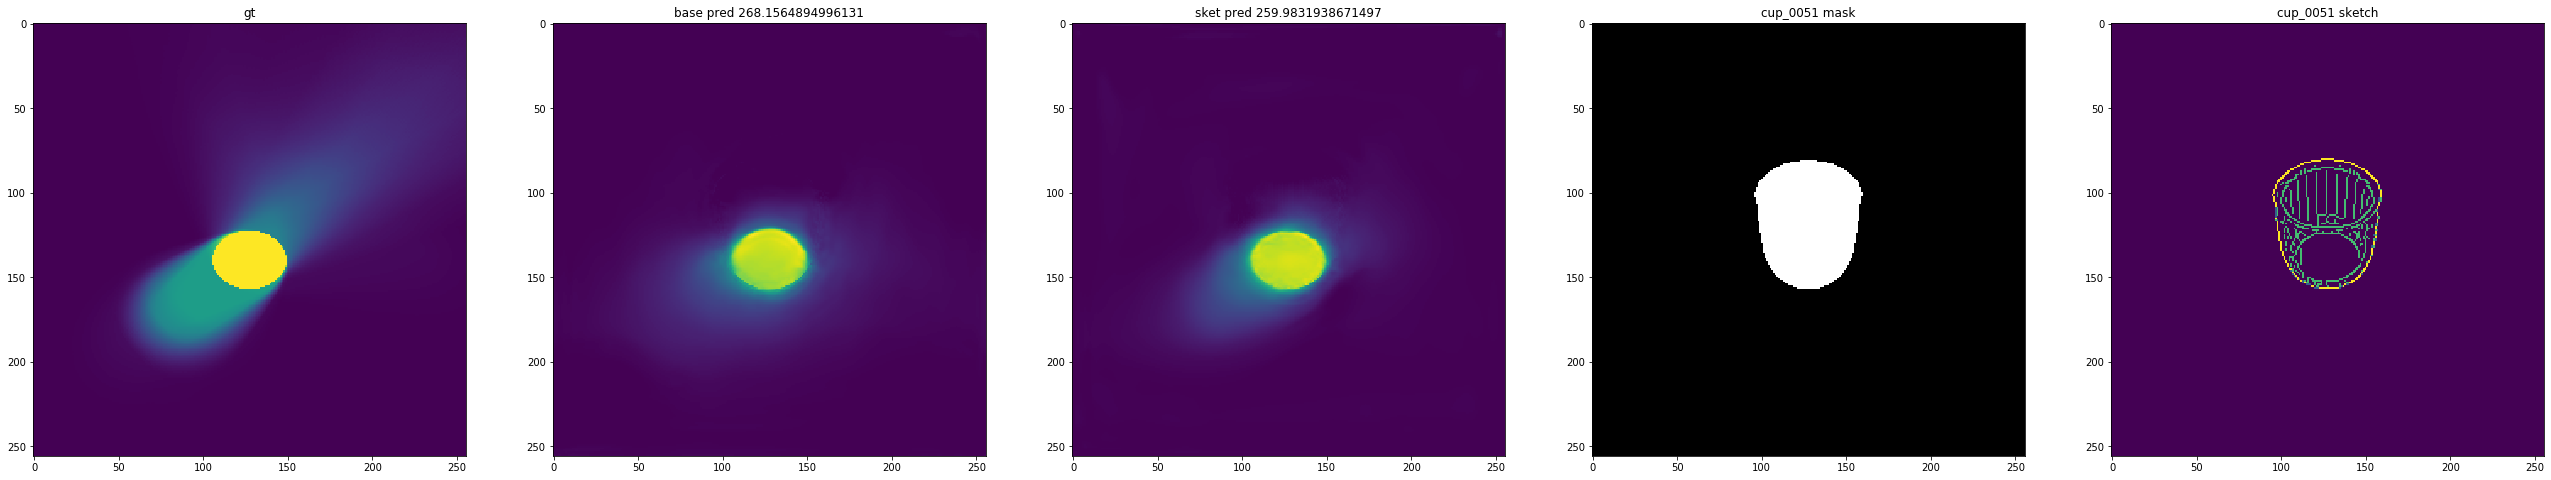

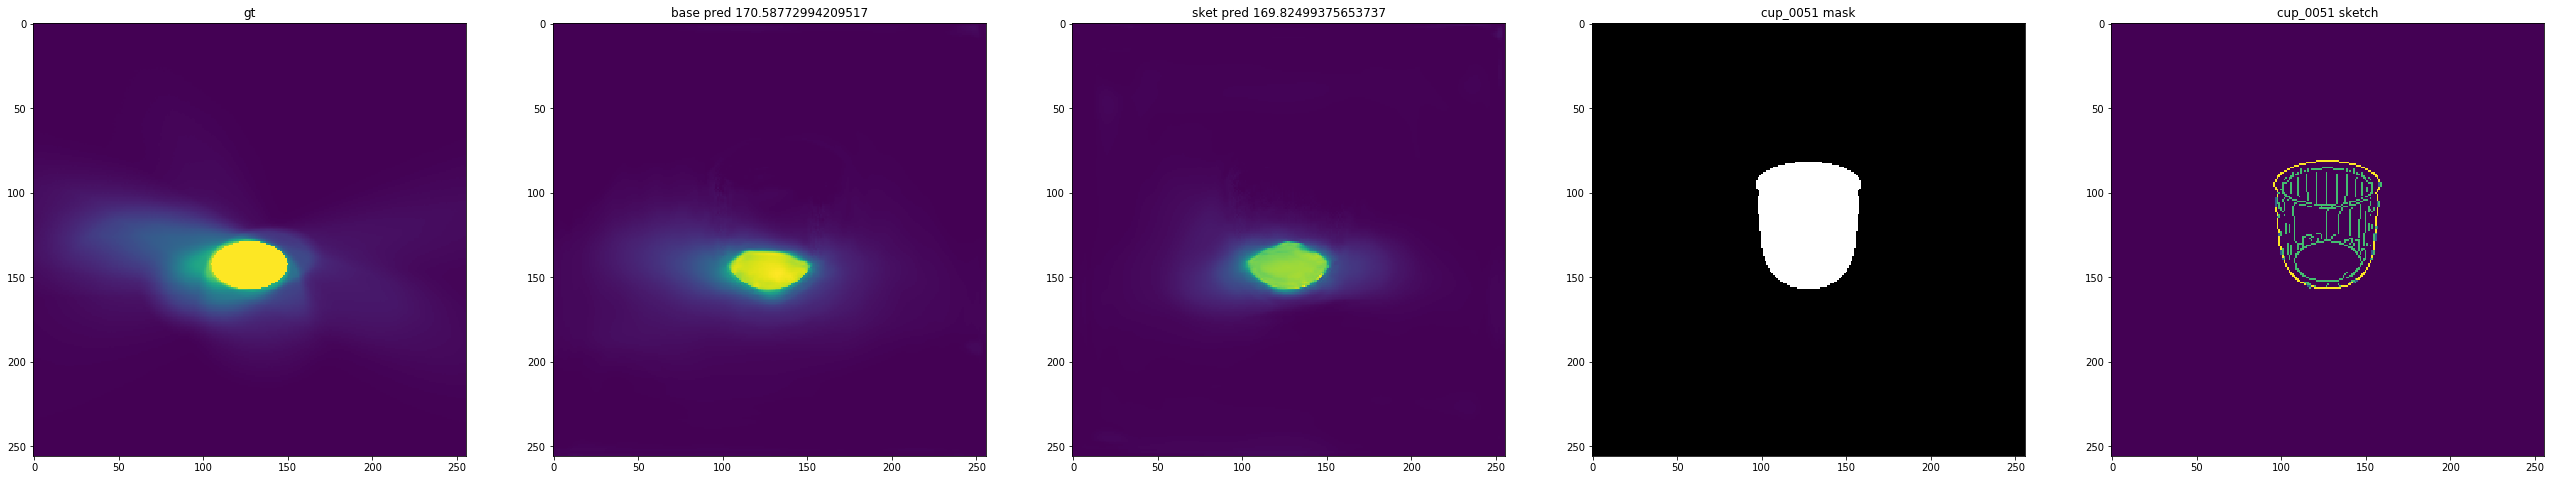

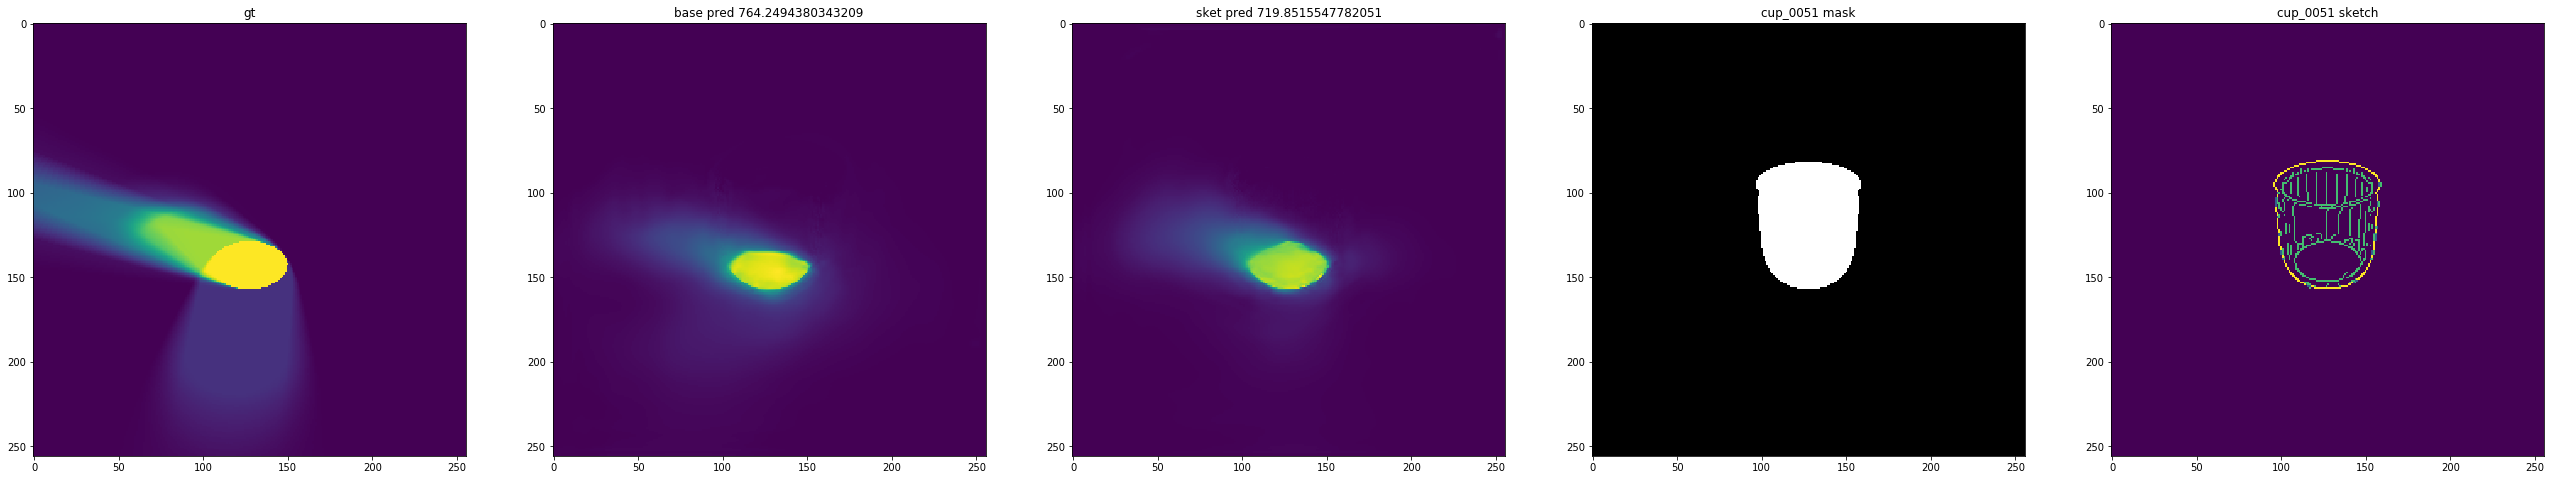

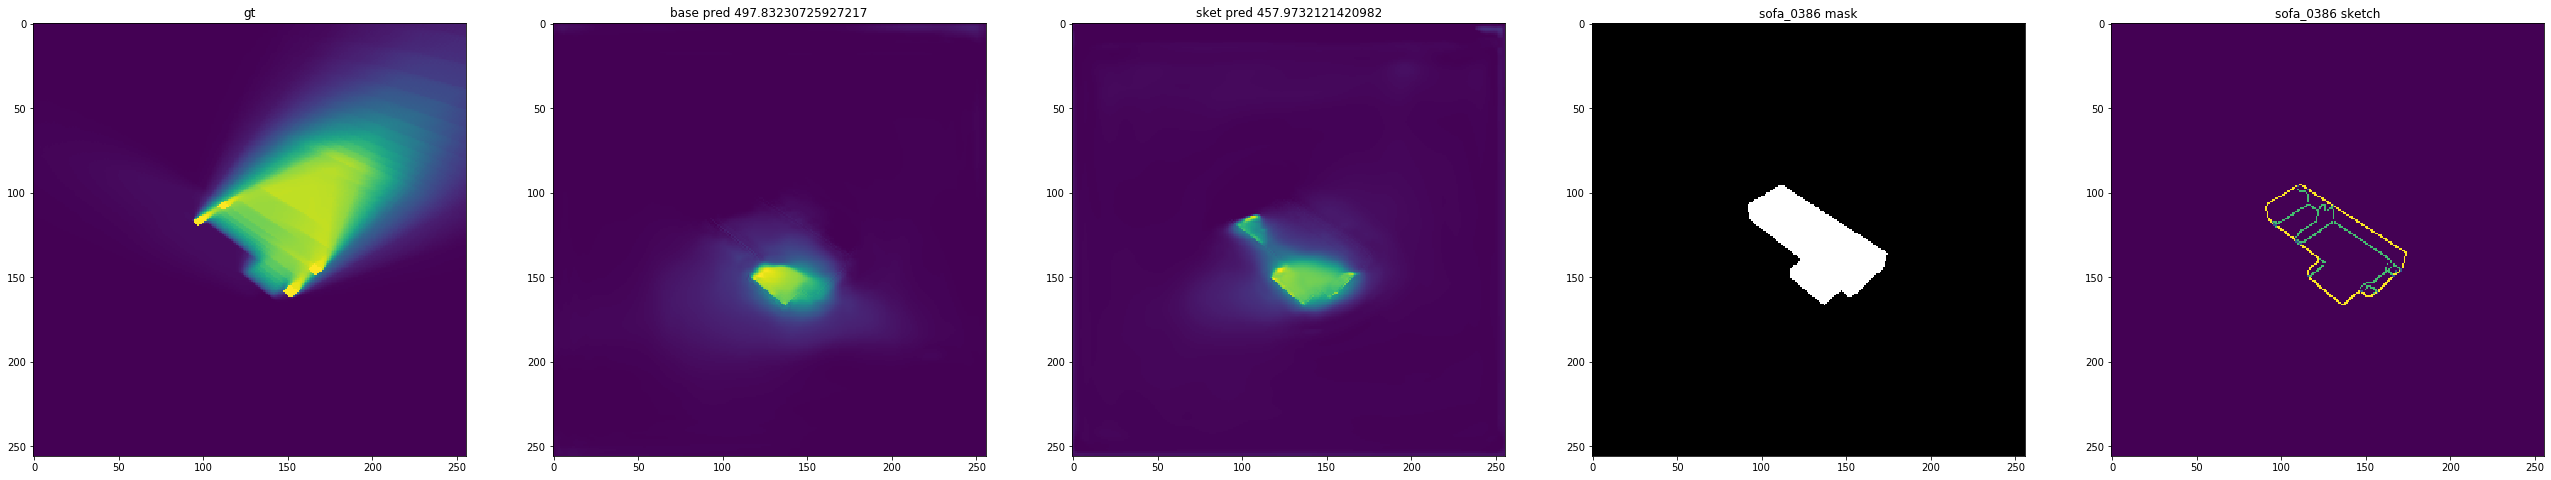

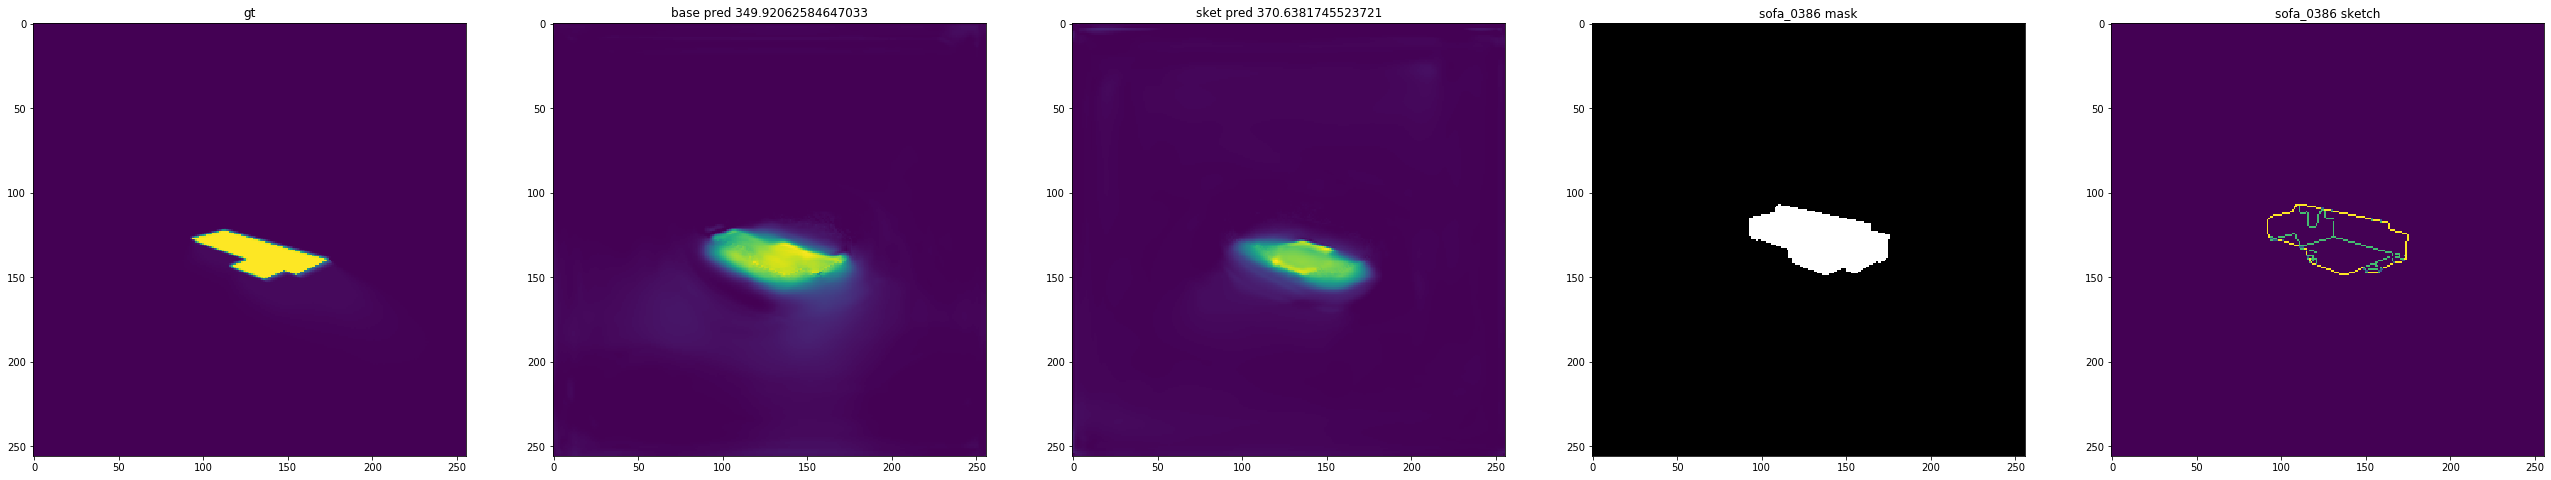

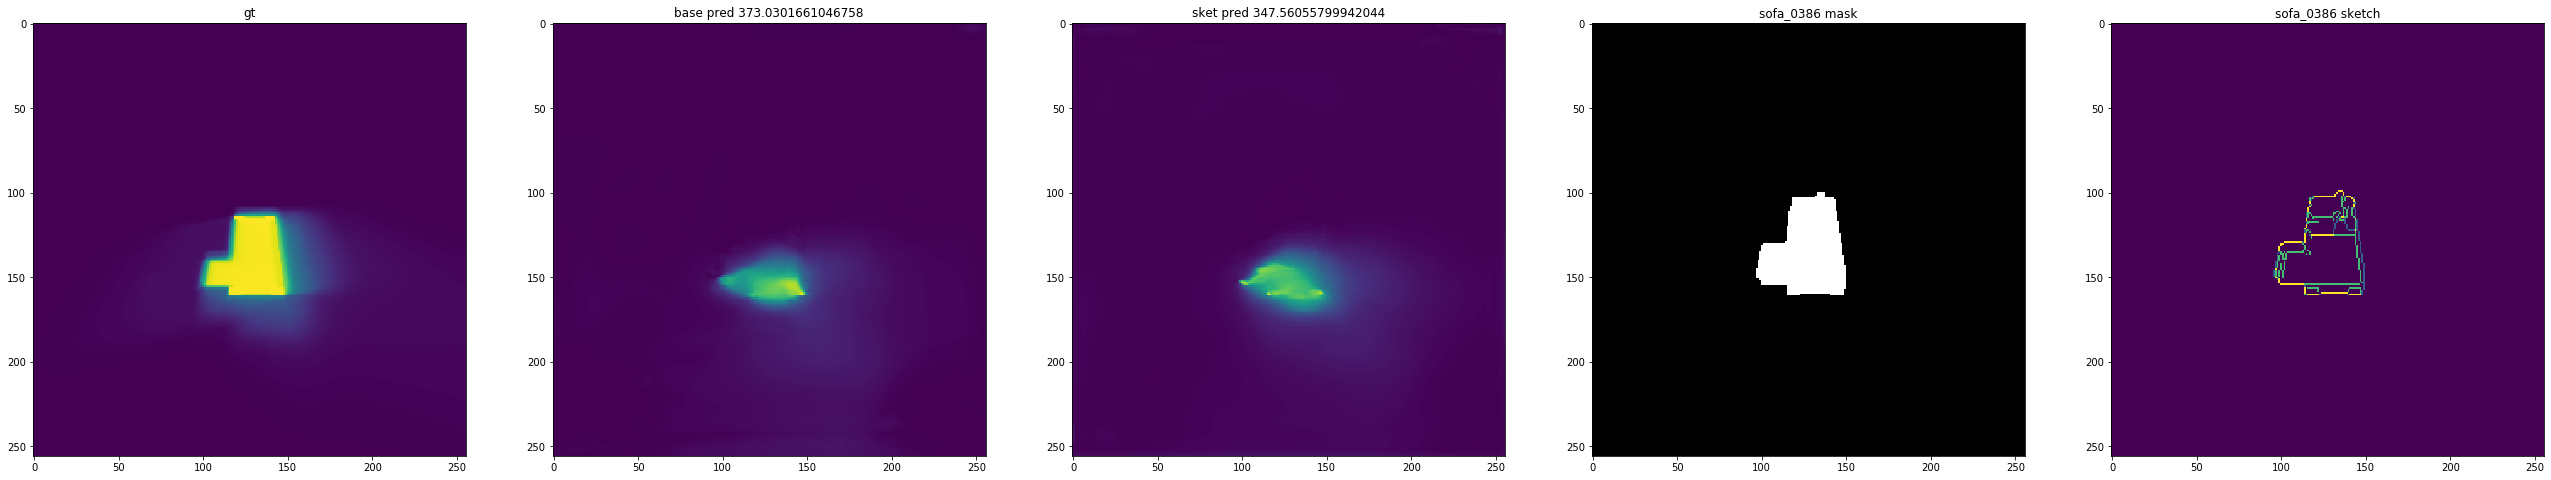

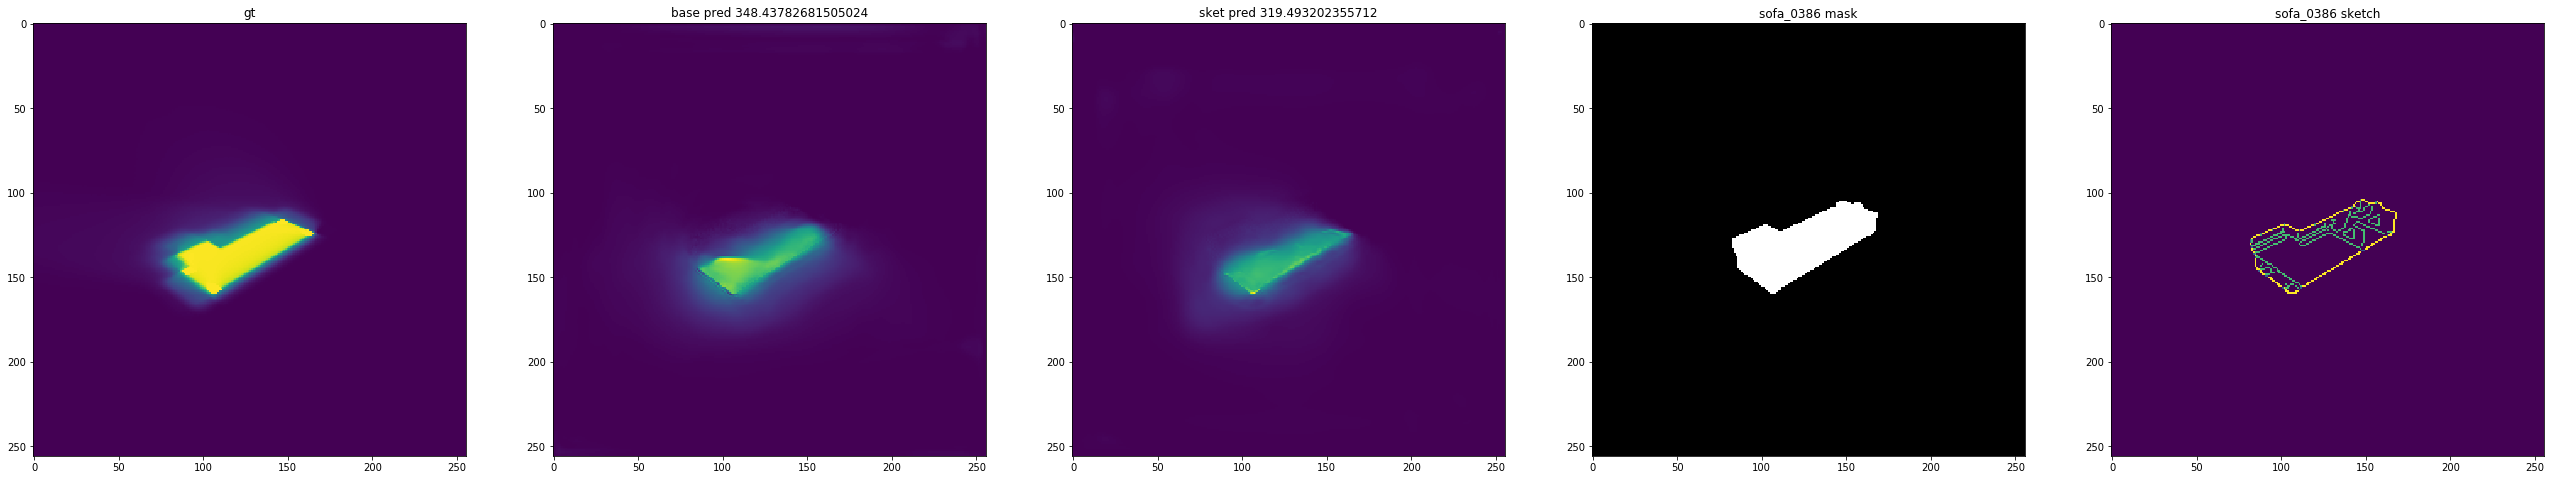

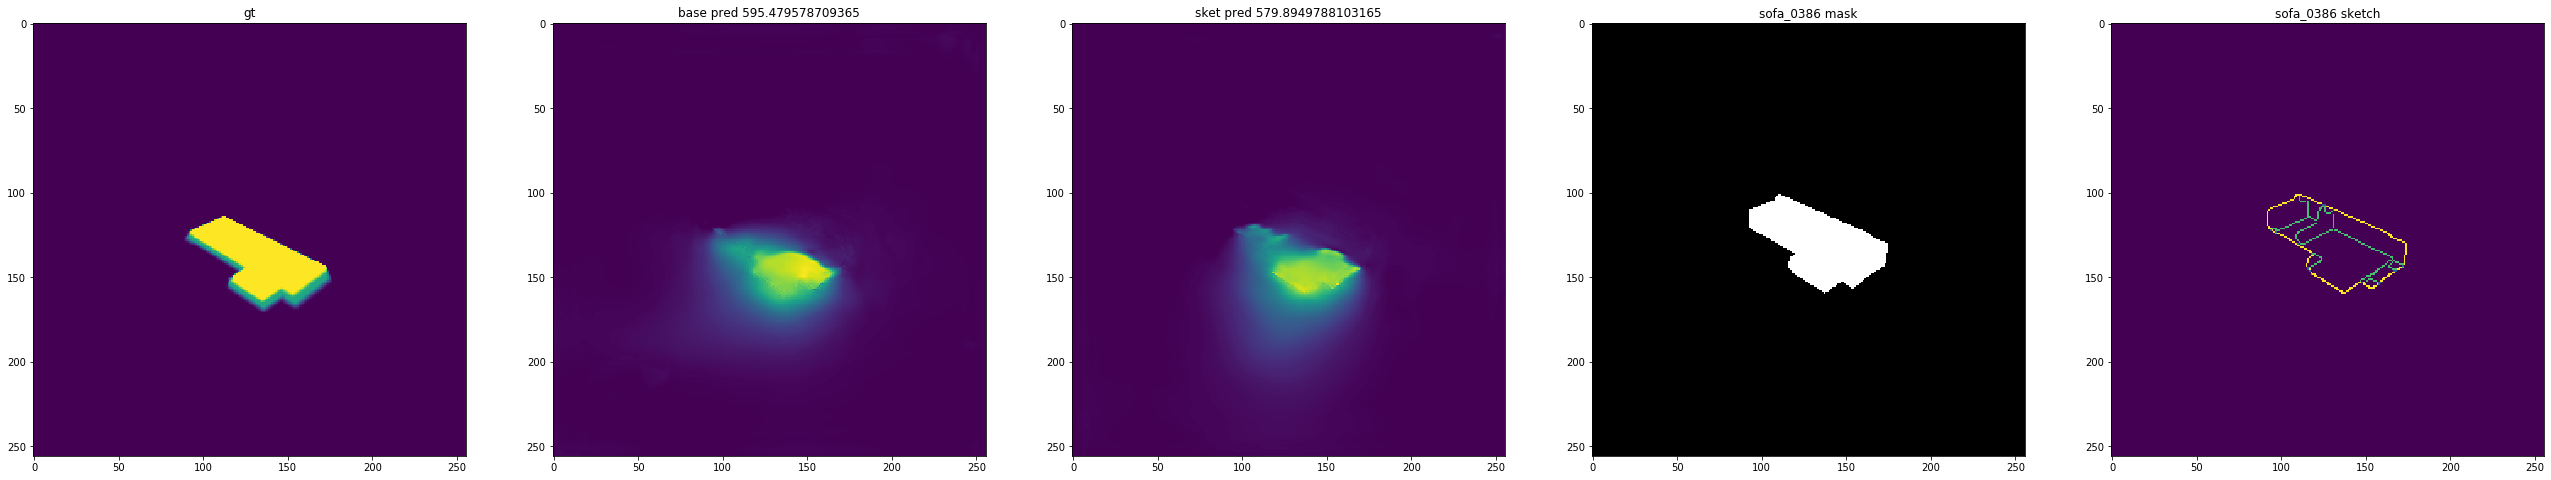

In [126]:
def plot_model(model_name, num=1):
    mask_files = get_files(join(mask_root, model_name))
    sketch_files = get_files(join(sketch_root, model_name))
    base_loss, sket_loss = [], []
    
    for i in range(num):
        mask = random.sample(mask_files, 1)[0]
        prefix = os.path.basename(mask)
        prefix = prefix[:prefix.find('_mask')]
        sketch = join(sketch_root, join(model_name, prefix + '_sketch.png'))
        shadow_base_file = join(base_root, join(model_name, prefix+'_shadow.npy'))

        light = pattern_generator.get_pattern(32, 16, num=random.randint(0,50), dataset=True)
        gt = get_gt(shadow_base_file, light)

        I_s,L_t = to_model_input(mask, light, device=device)
        base_pred_img, _ = baseline_model(I_s,L_t)
        base_pred_img = np.transpose(base_pred_img.cpu().detach().numpy()[0], (1,2,0))

        I_s, L_t = to_model_input(mask, light, sketch, device=device)
        sket_pred_img, _ = sketch_model(I_s, L_t)
        sket_pred_img = np.transpose(sket_pred_img.cpu().detach().numpy()[0], (1,2,0))

        gt = gt[:,:, np.newaxis]
        base_loss.append(loss(gt, base_pred_img))
        sket_loss.append(loss(gt, sket_pred_img))
        
        plt.figure(figsize=(15 * 3,10))
        plt.subplot(1,5,1)
        plt.imshow(np.squeeze(gt))
        plt.title('gt')
        
        plt.subplot(1,5,2)
        plt.imshow(np.squeeze(base_pred_img))
        plt.title('base pred {}'.format(loss(gt, base_pred_img)))
        
        plt.subplot(1,5,3)
        plt.imshow(np.squeeze(sket_pred_img))
        plt.title('sket pred {}'.format(loss(gt, sket_pred_img)))
        
        plt.subplot(1,5,4)
        plt.imshow(plt.imread(mask))
        plt.title('{} mask'.format(model_name))
        
        plt.subplot(1,5,5)
        plt.imshow(plt.imread(sketch))
        plt.title('{} sketch'.format(model_name))
    
plot_model('cup_0051', 5)
plot_model('sofa_0386', 5)